#Risheng Guo

Install necessary packages and libraries.

In [332]:
# import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
import seaborn as sns

# Determine Risk Exposures

Upload WRDS CRSP Stock Return Data: Read in the CSV file with monthly stock returns for 60 months (2017-2021) for the stocks.

In [569]:
return_data = pd.read_csv('Project-2017-21-Returns.csv')

exam the data

In [570]:
return_data

,PERMNO,date,TICKER,RET
0,10026,20170131,JJSF,-0.043918
1,10026,20170228,JJSF,0.048836
2,10026,20170331,JJSF,0.016293
3,10026,20170428,JJSF,-0.007229
4,10026,20170531,JJSF,-0.033289
...,...,...,...,...
114710,93436,20210831,TSLA,0.070605
114711,93436,20210930,TSLA,0.054042
114712,93436,20211029,TSLA,0.436530
114713,93436,20211130,TSLA,0.027612


check null

In [571]:
return_data.isnull().sum()

PERMNO     0
date       0
TICKER    62
RET       15
dtype: int64

not a lot of null, I choose to drop them

In [572]:
return_data = return_data.dropna()

check null again

In [573]:
return_data.isnull().sum()

PERMNO    0
date      0
TICKER    0
RET       0
dtype: int64

Seems RET have value 'C', I choose to drop it

In [574]:
return_data[return_data['RET'] == 'C']

,PERMNO,date,TICKER,RET
33195,16497,20170131,CNDT,C
33255,16498,20170131,HGV,C
33315,16499,20170131,PK,C
33555,16543,20170131,VREX,C
33675,16554,20170131,JELD,C
33795,16560,20170131,REVG,C
33855,16562,20170131,ANAB,C
33915,16570,20170131,JNCE,C
34096,16692,20170531,GDI,C
34813,18420,20190329,FOXA,C


In [575]:
return_data.drop(return_data[return_data['RET'] == 'C'].index, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


convert 'RET' column data type from object to float

In [576]:
return_data['RET'] = return_data['RET'].astype('float64')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [577]:
return_data

,PERMNO,date,TICKER,RET
0,10026,20170131,JJSF,-0.043918
1,10026,20170228,JJSF,0.048836
2,10026,20170331,JJSF,0.016293
3,10026,20170428,JJSF,-0.007229
4,10026,20170531,JJSF,-0.033289
...,...,...,...,...
114710,93436,20210831,TSLA,0.070605
114711,93436,20210930,TSLA,0.054042
114712,93436,20211029,TSLA,0.436530
114713,93436,20211130,TSLA,0.027612


Upload Fama-French monthly risk factor data

In [578]:
ff_factors = pd.read_csv('FF-Factors-2017-2021.csv')

exam the data

In [579]:
ff_factors.head()

,dateff,mktrf,smb,hml,rf
0,20170131,0.0194,-0.0113,-0.0274,0.0004
1,20170228,0.0357,-0.0204,-0.0167,0.0004
2,20170331,0.0017,0.0113,-0.0333,0.0003
3,20170428,0.0109,0.0072,-0.0213,0.0005
4,20170531,0.0106,-0.0252,-0.0375,0.0006


check null

In [580]:
ff_factors.isnull().sum()

dateff    0
mktrf     0
smb       0
hml       0
rf        0
dtype: int64

change coloumn name to prepare merge

In [581]:
ff_factors.rename(columns={'dateff':'date'}, inplace=True)

merge the data

In [582]:
d = pd.merge(return_data, ff_factors, on='date', how='outer')

check null again

In [583]:
d.isnull().sum()

PERMNO    0
date      0
TICKER    0
RET       0
mktrf     0
smb       0
hml       0
rf        0
dtype: int64

check data type

In [584]:
d.dtypes

PERMNO      int64
date        int64
TICKER     object
RET       float64
mktrf     float64
smb       float64
hml       float64
rf        float64
dtype: object

Create the for loop to iterate over each ticker company. Include
the FF Factor regression in the for loop as well to match each
result to the company name.

In [585]:
final = []
Ticker = []
Parameters = []

for TICKER, grp in d.groupby('TICKER'):
    y=grp['RET'] - grp['rf']
    X=grp[['mktrf','smb','hml']]
    ols = sm.OLS(y,sm.add_constant(X)).fit()
    Ticker.append(TICKER)
    Parameters.append(ols.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


store the regression outputs as dataframes to be used in following steps

In [586]:
dfTicker = pd.DataFrame(Ticker)
dfParameters = pd.DataFrame(Parameters)

Summarize the regression outputs of interest in a single table, containing one row for
each company
Create a new final dataframe that will store all the desired information from the above loop


In [587]:
Final = pd.DataFrame({'TICKER' : dfTicker[0]})
Final['mktrf'] = dfParameters['mktrf']
Final['smb'] = dfParameters['smb']
Final['hml'] = dfParameters['hml']


In [588]:
Final

,TICKER,mktrf,smb,hml
0,A,1.014152,-0.253674,-0.143608
1,AA,1.984149,0.527862,1.924844
2,AAL,1.315550,0.612825,1.248123
3,AAN,1.648965,0.242525,0.815613
4,AAON,0.516779,0.422130,-0.117068
...,...,...,...,...
1918,ZG,1.280585,2.183961,-0.578963
1919,ZION,1.084739,0.869374,1.151468
1920,ZNGA,0.101034,1.200987,-0.714916
1921,ZTS,0.728418,-0.560814,-0.179065


Import tickers data

In [589]:
t = pd.read_csv('ProjectTickers.csv')

In [590]:
t.head()

,Ticker,Name,RetYTD
0,A,Agilent Technologies,-0.2080
1,AA,Alcoa Corp,0.4731
2,AAL,American Airlines Gp,0.0579
3,AAN,Aarons Holdings Company,-0.1327
4,AAON,Aaon Inc,-0.3456


rename to prepare merge

In [591]:
Final.rename(columns={'TICKER':'Ticker'}, inplace=True)

In [592]:
Final = pd.merge(Final,t, on = 'Ticker', how = 'inner' )

In [593]:
Final

,Ticker,mktrf,smb,hml,Name,RetYTD
0,A,1.014152,-0.253674,-0.143608,Agilent Technologies,-0.2080
1,AA,1.984149,0.527862,1.924844,Alcoa Corp,0.4731
2,AAL,1.315550,0.612825,1.248123,American Airlines Gp,0.0579
3,AAN,1.648965,0.242525,0.815613,Aarons Holdings Company,-0.1327
4,AAON,0.516779,0.422130,-0.117068,Aaon Inc,-0.3456
...,...,...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104,Zendesk Inc,0.2002
1882,ZION,1.084739,0.869374,1.151468,Zions Bancorp,-0.0038
1883,ZNGA,0.101034,1.200987,-0.714916,Zynga Inc Cl A,0.3969
1884,ZTS,0.728418,-0.560814,-0.179065,Zoetis Inc Cl A,-0.2325


check outliers

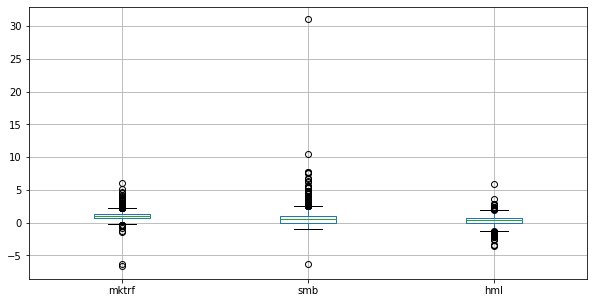

In [594]:
col1 = ['mktrf', 'smb', 'hml']
Final.boxplot(column=col1, figsize=(10, 5));

check the quantile bound

In [595]:
bound1 = []
for i in col1:
  Q1 = Final[i].quantile(0.25)
  Q3 = Final[i].quantile(0.75)
  IQR = Q3 - Q1
  lower_lim = Q1 - 1.5 * IQR
  upper_lim = Q3 + 1.5 * IQR
  tmp = [lower_lim,upper_lim]
  bound1.append(tmp)

In [596]:
bound1

[[-0.2055740332706516, 2.2636504217753632],
 [-1.4890846444497454, 2.524502758379921],
 [-1.2605211253458863, 1.973474055204112]]

Winsorize the data

In [597]:
print(Final['mktrf'].quantile(0.01))
print(Final['mktrf'].quantile(0.96))

-0.03616799847319567
2.1219538039580175


In [598]:
Final['mktrf'] = winsorize(Final['mktrf'], (0.09, 0.04))

In [599]:
print(Final['smb'].quantile(0.01))
print(Final['smb'].quantile(0.96))

-0.7510086728783688
2.514644186451361


In [600]:
Final['smb'] = winsorize(Final['smb'], (0.01, 0.04))

In [601]:
print(Final['hml'].quantile(0.03))
print(Final['hml'].quantile(0.99))

-1.1162753806270962
1.8109078946526964


In [602]:
Final['hml'] = winsorize(Final['hml'], (0.03, 0.01))

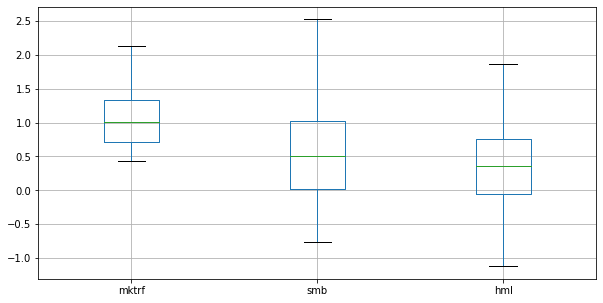

In [603]:
Final.boxplot(column=col1, figsize=(10, 5));

In [606]:
Final

,Ticker,mktrf,smb,hml,Name,RetYTD
0,A,1.014152,-0.253674,-0.143608,Agilent Technologies,-0.2080
1,AA,1.984149,0.527862,1.863158,Alcoa Corp,0.4731
2,AAL,1.315550,0.612825,1.248123,American Airlines Gp,0.0579
3,AAN,1.648965,0.242525,0.815613,Aarons Holdings Company,-0.1327
4,AAON,0.516779,0.422130,-0.117068,Aaon Inc,-0.3456
...,...,...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104,Zendesk Inc,0.2002
1882,ZION,1.084739,0.869374,1.151468,Zions Bancorp,-0.0038
1883,ZNGA,0.437495,1.200987,-0.714916,Zynga Inc Cl A,0.3969
1884,ZTS,0.728418,-0.560814,-0.179065,Zoetis Inc Cl A,-0.2325


Slice the data to only contain wanted variables

In [604]:
Fdata = Final[['Ticker','mktrf','smb','hml']]

In [605]:
Fdata

,Ticker,mktrf,smb,hml
0,A,1.014152,-0.253674,-0.143608
1,AA,1.984149,0.527862,1.863158
2,AAL,1.315550,0.612825,1.248123
3,AAN,1.648965,0.242525,0.815613
4,AAON,0.516779,0.422130,-0.117068
...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104
1882,ZION,1.084739,0.869374,1.151468
1883,ZNGA,0.437495,1.200987,-0.714916
1884,ZTS,0.728418,-0.560814,-0.179065


Save the ticker symbol and the 3 exposure values for each stock in the list
in a CSV file labelled FF-Exposures.csv

In [491]:
Fdata.to_csv('FF-Exposures.csv')

# Calculate Financial Ratios

upload Financial Report data for the year 2021 for each of the stocks with
tickers in the file “ProjectTickers.csv”.

In [229]:
r_data = pd.read_csv('Project-2021-Financials.csv')

exam the data

In [230]:
r_data

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,act,...,ceq,csho,dt,ebit,gp,lct,ni,sale,costat,prcc_c
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,937.000,...,974.400,35.375,205.100,65.500,286.800,336.800,35.800,1651.400,A,36.22
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,17336.000,...,-7340.000,647.728,46177.000,-5514.000,1913.000,19006.000,-1993.000,29882.000,A,17.96
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,1551.100,...,5906.200,112.927,NaN,805.310,1456.185,1756.869,618.720,3803.835,A,70.59
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,24239.000,...,35802.000,1764.082,19251.000,8966.000,26448.000,13105.000,7071.000,43075.000,A,140.74
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,8583.000,...,7497.000,1207.000,732.000,3678.000,8225.000,4240.000,3162.000,16434.000,A,143.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,266315,20211231,2021,INDL,C,D,STD,KRG,USD,NaN,...,3922.047,218.950,3221.045,33.373,67.357,NaN,-80.806,372.908,A,21.78
1882,294524,20211231,2021,INDL,C,D,STD,LYB,USD,12217.000,...,11858.000,329.536,13237.000,7397.000,10013.000,7230.000,5610.000,46173.000,A,92.23
1883,312009,20211231,2021,INDL,C,D,STD,FRO,USD,332.745,...,1653.014,203.531,2368.898,8.217,183.882,292.675,-11.148,749.381,A,7.07
1884,316056,20211231,2021,INDL,C,D,STD,ALLE,USD,1117.600,...,759.100,88.216,1534.500,534.600,1284.100,601.200,483.000,2867.400,A,132.44


check null

In [231]:
r_data.isnull().sum()

gvkey         0
datadate      0
fyear         0
indfmt        0
consol        0
popsrc        0
datafmt       0
tic           0
curcd         0
act         455
at            0
ceq           0
csho          0
dt          237
ebit          0
gp            0
lct         455
ni            0
sale          0
costat        0
prcc_c        0
dtype: int64

fill null value with median to not loss data

In [232]:
r_data[['act', 'dt','lct']] = r_data[['act', 'dt','lct']].fillna(r_data[['act', 'dt','lct']].median())

check null again

In [233]:
r_data.isnull().sum()

gvkey       0
datadate    0
fyear       0
indfmt      0
consol      0
popsrc      0
datafmt     0
tic         0
curcd       0
act         0
at          0
ceq         0
csho        0
dt          0
ebit        0
gp          0
lct         0
ni          0
sale        0
costat      0
prcc_c      0
dtype: int64

rename to prepare merge

In [237]:
r_data.rename(columns={'tic':'Ticker'}, inplace=True)
r_data.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,act,...,ceq,csho,dt,ebit,gp,lct,ni,sale,costat,prcc_c
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,937.0,...,974.4,35.375,205.1,65.50,286.800,336.800,35.80,1651.400,A,36.22
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,17336.0,...,-7340.0,647.728,46177.0,-5514.00,1913.000,19006.000,-1993.00,29882.000,A,17.96
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,1551.1,...,5906.2,112.927,1030.9,805.31,1456.185,1756.869,618.72,3803.835,A,70.59
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,24239.0,...,35802.0,1764.082,19251.0,8966.00,26448.000,13105.000,7071.00,43075.000,A,140.74
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,8583.0,...,7497.0,1207.000,732.0,3678.00,8225.000,4240.000,3162.00,16434.000,A,143.90


In [238]:
# merge beased on tic
df = pd.merge(r_data, t, on='Ticker', how='outer')

calculate 10 ratios

In [239]:
# P/E ratio, Invert ratio to make them "better behaved"
df['E/P'] = 1 / ((df['prcc_c'] * df['csho'] ) / df['ni'])

In [240]:
# Market / Book ratio, Invert ratio to make them "better behaved"
df['Book/Price'] = 1 / ((df['prcc_c'] * df['csho'] ) / df['ceq'])

In [241]:
# P/EBIT, Invert ratio to make them "better behaved"
df['EBIT/P'] = 1 / ((df['prcc_c'] * df['csho'] ) / df['ebit'])
# P/SALES, Invert ratio to make them "better behaved"
df['SALE/P'] = 1 / ((df['prcc_c'] * df['csho'] ) / df['sale'])

In [242]:
#return on assets (ROA) net income/total assets
df['ROA'] = df['ebit'] / df['at']
#total assets turnover (AT) sales/total assets
df['AT'] = df['sale']/df['at']
#debt to total assets (DAR) total debt/total assets
df['DAR'] = df['dt']/df['at']
#current ratio (CR) current assets/current liabilities
df['CR'] = df['act']/df['lct']
#net margin ratio net income/sales
df['net_margin'] = df['ebit'] / df['sale']
#gross margin ratio gross profits/sales
df['gross_margin'] = df['gp']/df['at']


exam data

In [243]:
df

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,act,...,E/P,Book/Price,EBIT/P,SALE/P,ROA,AT,DAR,CR,net_margin,gross_margin
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,937.000,...,0.027941,0.760488,0.051121,1.288865,0.042541,1.072547,0.133208,2.782067,0.039663,0.186270
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,17336.000,...,-0.171320,-0.630953,-0.473988,2.568684,-0.082958,0.449576,0.694736,0.912133,-0.184526,0.028781
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,1551.100,...,0.077616,0.740913,0.101023,0.477178,0.036600,0.172876,0.046852,0.882877,0.211710,0.066181
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,24239.000,...,0.028480,0.144202,0.036113,0.173496,0.119235,0.572836,0.256011,1.849599,0.208149,0.351721
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,8583.000,...,0.018205,0.043164,0.021176,0.094618,0.296159,1.323295,0.058942,2.024292,0.223804,0.662292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,266315,20211231,2021,INDL,C,D,STD,KRG,USD,1004.807,...,-0.016945,0.822451,0.006998,0.078199,0.004368,0.048813,0.421626,1.846542,0.089494,0.008817
1882,294524,20211231,2021,INDL,C,D,STD,LYB,USD,12217.000,...,0.184581,0.390154,0.243378,1.519193,0.201323,1.256682,0.360269,1.689765,0.160202,0.272522
1883,312009,20211231,2021,INDL,C,D,STD,FRO,USD,332.745,...,-0.007747,1.148753,0.005710,0.520778,0.001996,0.182017,0.575381,1.136910,0.010965,0.044663
1884,316056,20211231,2021,INDL,C,D,STD,ALLE,USD,1117.600,...,0.041341,0.064973,0.045758,0.245427,0.175221,0.939823,0.502950,1.858949,0.186441,0.420878


check null

In [244]:
df.isnull().sum()

gvkey           0
datadate        0
fyear           0
indfmt          0
consol          0
popsrc          0
datafmt         0
Ticker          0
curcd           0
act             0
at              0
ceq             0
csho            0
dt              0
ebit            0
gp              0
lct             0
ni              0
sale            0
costat          0
prcc_c          0
Name            0
RetYTD          0
E/P             0
Book/Price      0
EBIT/P          0
SALE/P          0
ROA             0
AT              0
DAR             0
CR              0
net_margin      0
gross_margin    0
dtype: int64

check outliers

In [373]:
col2 = ['Book/Price', 'E/P', 'EBIT/P', 'SALE/P','ROA','AT','DAR','CR','net_margin','gross_margin']

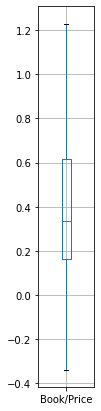

In [376]:
df.boxplot(column='Book/Price', figsize=(1, 7));

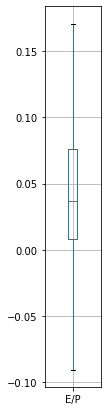

In [377]:
df.boxplot(column='E/P', figsize=(1, 7));

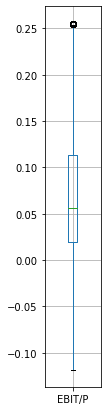

In [381]:
df.boxplot(column='EBIT/P', figsize=(1, 7));

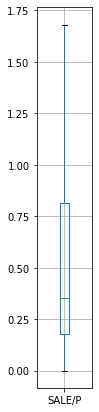

In [382]:
df.boxplot(column='SALE/P', figsize=(1, 7));

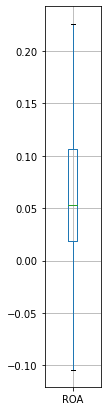

In [383]:
df.boxplot(column='ROA', figsize=(1, 7));

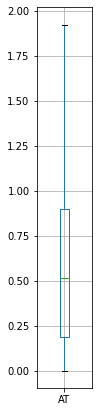

In [384]:
df.boxplot(column='AT', figsize=(1, 7));

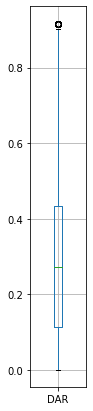

In [385]:
df.boxplot(column='DAR', figsize=(1, 7));

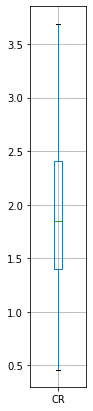

In [386]:
df.boxplot(column='CR', figsize=(1, 7));

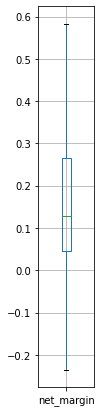

In [387]:
df.boxplot(column='net_margin', figsize=(1, 7));

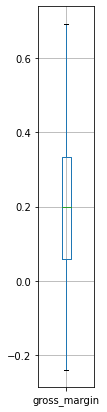

In [388]:
df.boxplot(column='gross_margin', figsize=(1, 7));

Winsorize the data

In [246]:
# find bound
bound = []
for i in col:
  Q1 = df[i].quantile(0.25)
  Q3 = df[i].quantile(0.75)
  IQR = Q3 - Q1
  lower_lim = Q1 - 1.5 * IQR
  upper_lim = Q3 + 1.5 * IQR
  tmp = [lower_lim,upper_lim]
  bound.append(tmp)

In [247]:
bound

[[-0.5180216024383288, 1.2930013906664006],
 [-0.09420060499289029, 0.17863602190947853],
 [-0.12163065231788973, 0.25509303847990195],
 [-0.7812908402477797, 1.7720783424627342],
 [-0.11275698808532107, 0.23753439832912926],
 [-0.8861483814320398, 1.971866287126221],
 [-0.36977998354041275, 0.9160299495683699],
 [-0.10978615930393709, 3.9135908131559187],
 [-0.2849659283165812, 0.5965018695925737],
 [-0.35319431794726885, 0.7437713469282667]]

In [248]:
print(df['Book/Price'].quantile(0.01))
print(df['Book/Price'].quantile(0.97))

-0.2989157665219422
1.2251194121170401


In [249]:
df['Book/Price'] = winsorize(df['Book/Price'], (0.01, 0.03))

In [250]:
print(df['E/P'].quantile(0.08))
print(df['E/P'].quantile(0.96))

-0.09029809603256078
0.17026815585880967


In [251]:
df['E/P'] = winsorize(df['E/P'], (0.08, 0.04))

In [252]:
print(df['EBIT/P'].quantile(0.05))
print(df['EBIT/P'].quantile(0.96))

-0.11757603814397245
0.25460244542782745


In [253]:
df['EBIT/P'] = winsorize(df['EBIT/P'], (0.05, 0.04))

In [254]:
print(df['SALE/P'].quantile(0.01))
print(df['SALE/P'].quantile(0.9))

0.0003273355993795138
1.673928621697347


In [255]:
df['SALE/P'] = winsorize(df['SALE/P'], (0.01, 0.10))

In [256]:
print(df['ROA'].quantile(0.07))
print(df['ROA'].quantile(0.95))

-0.10399990133172551
0.2257767885356311


In [257]:
df['ROA'] = winsorize(df['ROA'], (0.07, 0.05))

In [258]:
print(df['AT'].quantile(0.01))
print(df['AT'].quantile(0.96))

0.0008585370000651699
1.9220720572954517


In [259]:
df['AT'] = winsorize(df['AT'], (0.01, 0.04))

In [260]:
print(df['DAR'].quantile(0.01))
print(df['DAR'].quantile(0.98))

0.0012241790646555953
0.905893675843164


In [261]:
df['DAR'] = winsorize(df['DAR'], (0.01, 0.02))

In [262]:
print(df['CR'].quantile(0.01))
print(df['CR'].quantile(0.88))

0.46251919837100675
3.6888284331856904


In [263]:
df['CR'] = winsorize(df['CR'], (0.01, 0.12))

In [264]:
print(df['net_margin'].quantile(0.08))
print(df['net_margin'].quantile(0.95))

-0.22359701920005365
0.5828830887702902


In [265]:
df['net_margin'] = winsorize(df['net_margin'], (0.08, 0.05))

In [266]:
print(df['gross_margin'].quantile(0.02))
print(df['gross_margin'].quantile(0.98))

-0.2354968409936017
0.6900849639490095


In [267]:
df['gross_margin'] = winsorize(df['gross_margin'], (0.02, 0.02))

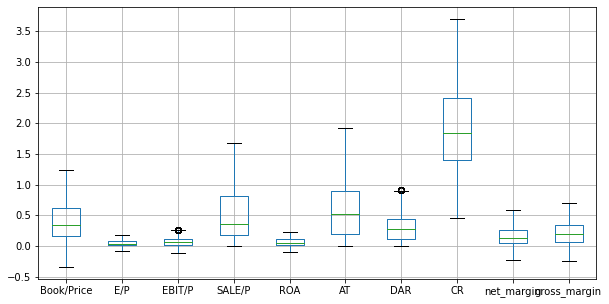

In [268]:
# Check outlier again
df.boxplot(column=col2, figsize=(10, 5));

Calculate Save the ticker symbol and the 10+ financial ratios for each stock
in the list in a CSV file labelled “Fin-Ratios.csv”

In [269]:
df_final = df[['Ticker', 'Book/Price', 'E/P', 'EBIT/P', 'SALE/P', 'ROA','AT','DAR','CR','net_margin','gross_margin']]
df_final

,Ticker,Book/Price,E/P,EBIT/P,SALE/P,ROA,AT,DAR,CR,net_margin,gross_margin
0,AIR,0.760488,0.027941,0.051121,1.288865,0.042541,1.072547,0.133208,2.782067,0.039663,0.186270
1,AAL,-0.337273,-0.090778,-0.117984,1.680424,-0.082958,0.449576,0.694736,0.912133,-0.184526,0.028781
2,PNW,0.740913,0.077616,0.101023,0.477178,0.036600,0.172876,0.046852,0.882877,0.211710,0.066181
3,ABT,0.144202,0.028480,0.036113,0.173496,0.119235,0.572836,0.256011,1.849599,0.208149,0.351721
4,AMD,0.043164,0.018205,0.021176,0.094618,0.225946,1.323295,0.058942,2.024292,0.223804,0.662292
...,...,...,...,...,...,...,...,...,...,...,...
1881,KRG,0.822451,-0.016945,0.006998,0.078199,0.004368,0.048813,0.421626,1.846542,0.089494,0.008817
1882,LYB,0.390154,0.171078,0.243378,1.519193,0.201323,1.256682,0.360269,1.689765,0.160202,0.272522
1883,FRO,1.148753,-0.007747,0.005710,0.520778,0.001996,0.182017,0.575381,1.136910,0.010965,0.044663
1884,ALLE,0.064973,0.041341,0.045758,0.245427,0.175221,0.939823,0.502950,1.858949,0.186441,0.420878


In [ ]:
df_final.to_csv('Fin-Ratios.csv')

# Industry Indicators

Load "Project-2021-Sector.csv" into Pandas dataframes

In [270]:
sector_data = pd.read_csv('Project-2021-Sector.csv')

exam the data

In [271]:
sector_data

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,curcd,costat,ggroup
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,A,2010
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,A,2030
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,A,5510
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,A,3510
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,A,4530
...,...,...,...,...,...,...,...,...,...,...,...
1881,266315,20211231,2021,INDL,C,D,STD,KRG,USD,A,6010
1882,294524,20211231,2021,INDL,C,D,STD,LYB,USD,A,1510
1883,312009,20211231,2021,INDL,C,D,STD,FRO,USD,A,1010
1884,316056,20211231,2021,INDL,C,D,STD,ALLE,USD,A,2010


check null

In [272]:
sector_data.isnull().sum()

gvkey       0
datadate    0
fyear       0
indfmt      0
consol      0
popsrc      0
datafmt     0
tic         0
curcd       0
costat      0
ggroup      0
dtype: int64

Merge the datasets based on each stock's ticker symbol (TIC)

In [273]:
# rename to prepair merge
sector_data.rename(columns={'tic':'Ticker'}, inplace=True)

In [274]:
ds = pd.merge(sector_data, t, on='Ticker', how='outer')

exam data

In [275]:
ds

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,Ticker,curcd,costat,ggroup,Name,RetYTD
0,1004,20210531,2020,INDL,C,D,STD,AIR,USD,A,2010,AAR Corp,0.2944
1,1045,20211231,2021,INDL,C,D,STD,AAL,USD,A,2030,American Airlines Gp,0.0579
2,1075,20211231,2021,INDL,C,D,STD,PNW,USD,A,5510,Pinnacle West Capital Corp,0.0985
3,1078,20211231,2021,INDL,C,D,STD,ABT,USD,A,3510,Abbott Laboratories,-0.1638
4,1161,20211231,2021,INDL,C,D,STD,AMD,USD,A,4530,Adv Micro Devices,-0.3533
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,266315,20211231,2021,INDL,C,D,STD,KRG,USD,A,6010,Kite Realty Group Trust,0.0275
1882,294524,20211231,2021,INDL,C,D,STD,LYB,USD,A,1510,Lyondellbasell Industries NV,0.1664
1883,312009,20211231,2021,INDL,C,D,STD,FRO,USD,A,1010,Frontline Ltd,0.3380
1884,316056,20211231,2021,INDL,C,D,STD,ALLE,USD,A,2010,Allegion Plc,-0.1888


check null

In [276]:
ds.isnull().sum()

gvkey       0
datadate    0
fyear       0
indfmt      0
consol      0
popsrc      0
datafmt     0
Ticker      0
curcd       0
costat      0
ggroup      0
Name        0
RetYTD      0
dtype: int64

In [296]:
# calcualte mean stock return group by ggroup
avg = ds.groupby(['ggroup']).mean()

1010(energe) has the highest average stock returns. It make sense due to the rise of Brent Crude Oil Price in early 2022.

In [297]:
avg[avg.RetYTD == avg.RetYTD.max()]

,gvkey,datadate,fyear,RetYTD
ggroup,,,,
1010,80503.693333,2.021119e+07,2020.973333,0.515035


4530(Semiconductors & Semiconductor Equipment) has the lowest average stock returns. It also make sense due to the rise in chip's capacity and the drop of chip price in early 2022. Because manufacturers build more factories to produce chips, the gap bewtween low supply and high demand at the start of covid no longer exist.

In [298]:
avg[avg.RetYTD == avg.RetYTD.min()]

,gvkey,datadate,fyear,RetYTD
ggroup,,,,
4530,81051.472727,2.021099e+07,2020.854545,-0.252813


slice to only contain two columns

In [277]:
dsf = ds[['Ticker','ggroup']]

exam the data

In [278]:
dsf

,Ticker,ggroup
0,AIR,2010
1,AAL,2030
2,PNW,5510
3,ABT,3510
4,AMD,4530
...,...,...
1881,KRG,6010
1882,LYB,1510
1883,FRO,1010
1884,ALLE,2010


count the number of industries

In [303]:
dsf.ggroup.nunique()

24

count how many stock in each industries. 2010(capital goods) has the most stocks. 5010(Telecommunication Services) has the least stocks

In [305]:
dsf.groupby('ggroup').Ticker.nunique().sort_values()

ggroup
5010     13
3030     17
3010     17
2510     25
2030     39
5020     42
3020     44
4530     55
5510     58
4030     61
2020     63
2520     63
2530     64
1010     75
4520     82
2550     86
4020     92
1510     95
4510    118
3510    121
6010    131
3520    163
4010    179
2010    183
Name: Ticker, dtype: int64

[Text(0, 0, '2010'),
 Text(0, 0, '4010'),
 Text(0, 0, '3520'),
 Text(0, 0, '6010'),
 Text(0, 0, '3510'),
 Text(0, 0, '4510'),
 Text(0, 0, '1510'),
 Text(0, 0, '4020'),
 Text(0, 0, '2550'),
 Text(0, 0, '4520'),
 Text(0, 0, '1010'),
 Text(0, 0, '2530'),
 Text(0, 0, '2020'),
 Text(0, 0, '2520'),
 Text(0, 0, '4030'),
 Text(0, 0, '5510'),
 Text(0, 0, '4530'),
 Text(0, 0, '3020'),
 Text(0, 0, '5020'),
 Text(0, 0, '2030'),
 Text(0, 0, '2510'),
 Text(0, 0, '3030'),
 Text(0, 0, '3010'),
 Text(0, 0, '5010')]

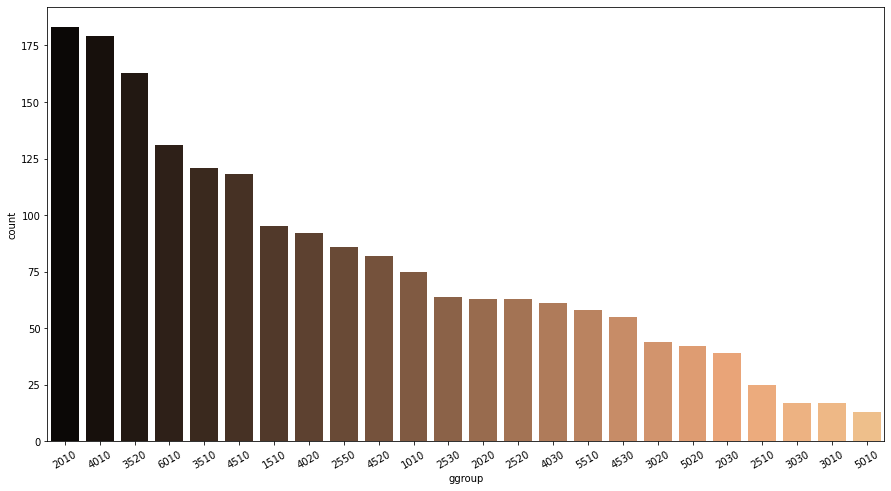

In [439]:
plt.figure(figsize = (15,8))
ax = sns.countplot(x = 'ggroup',data = dsf, palette="copper", order=dsf['ggroup'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

Save the ticker symbol and the industry indicators for each stock in the list
in a CSV file labelled “Industry.csv”

In [ ]:
dsf.to_csv('Industry.csv')

# Run OLS explanatory for 4 categories:

## a. Risk Regressions:

In [607]:
dr = Final

In [608]:
dr

,Ticker,mktrf,smb,hml,Name,RetYTD
0,A,1.014152,-0.253674,-0.143608,Agilent Technologies,-0.2080
1,AA,1.984149,0.527862,1.863158,Alcoa Corp,0.4731
2,AAL,1.315550,0.612825,1.248123,American Airlines Gp,0.0579
3,AAN,1.648965,0.242525,0.815613,Aarons Holdings Company,-0.1327
4,AAON,0.516779,0.422130,-0.117068,Aaon Inc,-0.3456
...,...,...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104,Zendesk Inc,0.2002
1882,ZION,1.084739,0.869374,1.151468,Zions Bancorp,-0.0038
1883,ZNGA,0.437495,1.200987,-0.714916,Zynga Inc Cl A,0.3969
1884,ZTS,0.728418,-0.560814,-0.179065,Zoetis Inc Cl A,-0.2325


In [609]:
y1 = dr['RetYTD']
X1 = dr[['mktrf','smb','hml']]
model1 = sm.OLS(y1,sm.add_constant(X1)).fit()
model1.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     63.55
Date:                Thu, 28 Apr 2022   Prob (F-statistic):           3.89e-39
Time:                        00:53:57   Log-Likelihood:                 77.279
No. Observations:                1886   AIC:                            -146.6
Df Residuals:                    1882   BIC:                            -124.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0786      0.014     -5.742      0.000      -0.105      -0.052
mktrf         -0.0160      0.012     -1.293      0.196      -0.040       0.008
smb           -0.0113      0.007     -1.591      0.112      -0.025       0.003
hml            0.1192      0.009     13.741      0.000       0.102       0.136
==============================================================================
Omnibus:                      658.924   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3663.748
Skew:                           1.540   Prob(JB):                         0.00
Kurtosis:                       9.094   Cond. No.                         5.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression has a Adj.R-squared of 0.091, which means 9.1% of the variance in YetYTD can be represented by the risk exposures. Since the Adj. R-squared is only around 9%. risk exposures have a really week explanatory power. 

mktrf and smb all have a negative corrolation with RetYTD, and since their P-value are large (> 0,05), their coefficient are not stistical significant difference than 0,

hml have a positive corrolation with YetYTD, and its P value is small (<0.05), the difference between 0 and its coefficient is stistical significan

##b. Financial Characteristics:

In [283]:
dfc = pd.merge(df_final, t, on='Ticker', how='outer')

In [284]:
dfc

,Ticker,Book/Price,E/P,EBIT/P,SALE/P,ROA,AT,DAR,CR,net_margin,gross_margin,Name,RetYTD
0,AIR,0.760488,0.027941,0.051121,1.288865,0.042541,1.072547,0.133208,2.782067,0.039663,0.186270,AAR Corp,0.2944
1,AAL,-0.337273,-0.090778,-0.117984,1.680424,-0.082958,0.449576,0.694736,0.912133,-0.184526,0.028781,American Airlines Gp,0.0579
2,PNW,0.740913,0.077616,0.101023,0.477178,0.036600,0.172876,0.046852,0.882877,0.211710,0.066181,Pinnacle West Capital Corp,0.0985
3,ABT,0.144202,0.028480,0.036113,0.173496,0.119235,0.572836,0.256011,1.849599,0.208149,0.351721,Abbott Laboratories,-0.1638
4,AMD,0.043164,0.018205,0.021176,0.094618,0.225946,1.323295,0.058942,2.024292,0.223804,0.662292,Adv Micro Devices,-0.3533
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,KRG,0.822451,-0.016945,0.006998,0.078199,0.004368,0.048813,0.421626,1.846542,0.089494,0.008817,Kite Realty Group Trust,0.0275
1882,LYB,0.390154,0.171078,0.243378,1.519193,0.201323,1.256682,0.360269,1.689765,0.160202,0.272522,Lyondellbasell Industries NV,0.1664
1883,FRO,1.148753,-0.007747,0.005710,0.520778,0.001996,0.182017,0.575381,1.136910,0.010965,0.044663,Frontline Ltd,0.3380
1884,ALLE,0.064973,0.041341,0.045758,0.245427,0.175221,0.939823,0.502950,1.858949,0.186441,0.420878,Allegion Plc,-0.1888


In [285]:
y2 = dfc['RetYTD']
X2 = dfc.drop(columns=['RetYTD','Ticker','Name '])
model2 = sm.OLS(y2,sm.add_constant(X2)).fit()
model2.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     23.86
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           9.22e-43
Time:                        18:31:38   Log-Likelihood:                 99.249
No. Observations:                1886   AIC:                            -176.5
Df Residuals:                    1875   BIC:                            -115.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0794      0.025     -3.160      0.002      -0.129      -0.030
Book/Price       0.1713      0.024      7.273      0.000       0.125       0.218
E/P             -0.3811      0.148     -2.567      0.010      -0.672      -0.090
EBIT/P          -0.0973      0.142     -0.686      0.493      -0.376       0.181
SALE/P           0.0933      0.021      4.472      0.000       0.052       0.134
ROA              0.7228      0.124      5.849      0.000       0.480       0.965
AT              -0.1002      0.023     -4.308      0.000      -0.146      -0.055
DAR              0.0611      0.027      2.222      0.026       0.007       0.115
CR              -0.0348      0.007     -5.200      0.000      -0.048      -0.022
net_margin      -0.0776      0.048     -1.623      0.105      -0.171       0.016
gross_margin    -0.0232      0.045     -0.511      0.609      -0.112       0.066
==============================================================================
Omnibus:                      672.659   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4391.820
Skew:                           1.521   Prob(JB):                         0.00
Kurtosis:                       9.829   Cond. No.                         87.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression has a Adj.R-squared of 0.108, which means 10.8% of the variance in YetYTD can be represented by the the Financial Characteristics. Since the Adj. R-squared is only around 11%. The finance ratios I choose also have a really week explanatory power. 


EBIT/P, net_margin, gross_margin have a large p value (> 0.05), the difference between 0 and thier coef is not statistical significant.

##c. Industry Dummies:

slice the data

In [286]:
dsr = ds[['Ticker','ggroup','RetYTD']]

In [287]:
# dummify the ggroup coloumn
dsr = pd.get_dummies(dsr, columns=['ggroup'])

In [288]:
dsr.head()

,Ticker,RetYTD,ggroup_1010,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,ggroup_2530,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,AIR,0.2944,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAL,0.0579,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PNW,0.0985,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,ABT,-0.1638,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMD,-0.3533,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


run a regression

In [289]:
X3 = dsr.drop(columns=['Ticker','RetYTD','ggroup_1010'])
y3 = dsr['RetYTD']
sm.OLS(y3, sm.add_constant(X3)).fit().summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          6.29e-141
Time:                        18:31:45   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5150      0.023     22.140      0.000       0.469       0.561
ggroup_1510    -0.4572      0.031    -14.692      0.000      -0.518      -0.396
ggroup_2010    -0.6056      0.028    -21.924      0.000      -0.660      -0.551
ggroup_2020    -0.5502      0.034    -15.980      0.000      -0.618      -0.483
ggroup_2030    -0.5825      0.040    -14.646      0.000      -0.660      -0.504
ggroup_2510    -0.7230      0.047    -15.540      0.000      -0.814      -0.632
ggroup_2520    -0.7236      0.034    -21.018      0.000      -0.791      -0.656
ggroup_2530    -0.5776      0.034    -16.849      0.000      -0.645      -0.510
ggroup_2550    -0.6663      0.032    -20.932      0.000      -0.729      -0.604
ggroup_3010    -0.4367      0.054     -8.070      0.000      -0.543      -0.331
ggroup_3020    -0.4763      0.038    -12.449      0.000      -0.551      -0.401
ggroup_3030    -0.6688      0.054    -12.359      0.000      -0.775      -0.563
ggroup_3510    -0.5815      0.030    -19.639      0.000      -0.640      -0.523
ggroup_3520    -0.6790      0.028    -24.154      0.000      -0.734      -0.624
ggroup_4010    -0.6029      0.028    -21.756      0.000      -0.657      -0.549
ggroup_4020    -0.6375      0.031    -20.342      0.000      -0.699      -0.576
ggroup_4030    -0.5113      0.035    -14.719      0.000      -0.579      -0.443
ggroup_4510    -0.6237      0.030    -20.963      0.000      -0.682      -0.565
ggroup_4520    -0.6871      0.032    -21.346      0.000      -0.750      -0.624
ggroup_4530    -0.7678      0.036    -21.470      0.000      -0.838      -0.698
ggroup_5010    -0.5032      0.061     -8.314      0.000      -0.622      -0.384
ggroup_5020    -0.5859      0.039    -15.090      0.000      -0.662      -0.510
ggroup_5510    -0.4743      0.035    -13.464      0.000      -0.543      -0.405
ggroup_6010    -0.5509      0.029    -18.884      0.000      -0.608      -0.494
==============================================================================
Omnibus:                      403.265   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2314.656
Skew:                           0.877   Prob(JB):                         0.00
Kurtosis:                       8.136   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


*   For explanatory power, we need to look at the Adj. R-squared. The regression has a Adj.R-squared of 0.317, which means 32% of the variance in y can be represented by the input variable. Since the Adj. R-squared is only around 30%, it is hard to say that there is a strong explanatory power.
*   since constant has the highest coefficient, we can interpret ggroup 1010(energy) experience the highest stock returns, about 52%.
*   P value for all industry is really small, the change in stock return for all industry is statitical significant





##d. Combined Regressions:

In [610]:
dcrt = pd.merge(dr, dfc, on='Ticker', how='outer')

In [611]:
dcrt

,Ticker,mktrf,smb,hml,Name _x,RetYTD_x,Book/Price,E/P,EBIT/P,SALE/P,ROA,AT,DAR,CR,net_margin,gross_margin,Name _y,RetYTD_y
0,A,1.014152,-0.253674,-0.143608,Agilent Technologies,-0.2080,0.111695,0.025079,0.029204,0.130970,0.131621,0.590285,0.271929,2.224239,0.222978,0.340682,Agilent Technologies,-0.2080
1,AA,1.984149,0.527862,1.863158,Alcoa Corp,0.4731,0.425940,0.039111,0.189357,1.107882,0.138236,0.808785,0.121531,1.559417,0.170918,0.199601,Alcoa Corp,0.4731
2,AAL,1.315550,0.612825,1.248123,American Airlines Gp,0.0579,-0.337273,-0.090778,-0.117984,1.680424,-0.082958,0.449576,0.694736,0.912133,-0.184526,0.028781,American Airlines Gp,0.0579
3,AAN,1.648965,0.242525,0.815613,Aarons Holdings Company,-0.1327,0.940491,0.143967,0.206699,1.680424,0.109513,1.280475,0.221912,1.846542,0.085525,0.692567,Aarons Holdings Company,-0.1327
4,AAON,0.516779,0.422130,-0.117068,Aaon Inc,-0.3456,0.111730,0.014083,0.017648,0.128111,0.113249,0.822106,0.087740,2.513369,0.137754,0.254159,Aaon Inc,-0.3456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104,Zendesk Inc,0.2002,0.038577,-0.017636,-0.011941,0.105556,-0.061774,0.546083,0.490990,1.556646,-0.113122,0.448148,Zendesk Inc,0.2002
1882,ZION,1.084739,0.869374,1.151468,Zions Bancorp,-0.0038,0.733347,0.117891,0.188062,0.310130,0.019324,0.031867,0.011061,1.846542,0.583142,0.034195,Zions Bancorp,-0.0038
1883,ZNGA,0.437495,1.200987,-0.714916,Zynga Inc Cl A,0.3969,0.430106,-0.014402,0.032535,0.387066,0.037019,0.440406,0.234993,1.054497,0.084056,0.318373,Zynga Inc Cl A,0.3969
1884,ZTS,0.728418,-0.560814,-0.179065,Zoetis Inc Cl A,-0.2325,0.039394,0.017664,0.024618,0.067515,0.204245,0.560144,0.488058,3.691167,0.364629,0.416978,Zoetis Inc Cl A,-0.2325


In [612]:
dcrt.drop(columns=['Name _x','RetYTD_x','Name _y','RetYTD_y'])

,Ticker,mktrf,smb,hml,Book/Price,E/P,EBIT/P,SALE/P,ROA,AT,DAR,CR,net_margin,gross_margin
0,A,1.014152,-0.253674,-0.143608,0.111695,0.025079,0.029204,0.130970,0.131621,0.590285,0.271929,2.224239,0.222978,0.340682
1,AA,1.984149,0.527862,1.863158,0.425940,0.039111,0.189357,1.107882,0.138236,0.808785,0.121531,1.559417,0.170918,0.199601
2,AAL,1.315550,0.612825,1.248123,-0.337273,-0.090778,-0.117984,1.680424,-0.082958,0.449576,0.694736,0.912133,-0.184526,0.028781
3,AAN,1.648965,0.242525,0.815613,0.940491,0.143967,0.206699,1.680424,0.109513,1.280475,0.221912,1.846542,0.085525,0.692567
4,AAON,0.516779,0.422130,-0.117068,0.111730,0.014083,0.017648,0.128111,0.113249,0.822106,0.087740,2.513369,0.137754,0.254159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104,0.038577,-0.017636,-0.011941,0.105556,-0.061774,0.546083,0.490990,1.556646,-0.113122,0.448148
1882,ZION,1.084739,0.869374,1.151468,0.733347,0.117891,0.188062,0.310130,0.019324,0.031867,0.011061,1.846542,0.583142,0.034195
1883,ZNGA,0.437495,1.200987,-0.714916,0.430106,-0.014402,0.032535,0.387066,0.037019,0.440406,0.234993,1.054497,0.084056,0.318373
1884,ZTS,0.728418,-0.560814,-0.179065,0.039394,0.017664,0.024618,0.067515,0.204245,0.560144,0.488058,3.691167,0.364629,0.416978


In [613]:
dcr = pd.merge(dcrt,dsr, on='Ticker', how='outer')

In [614]:
dcr

,Ticker,mktrf,smb,hml,Name _x,RetYTD_x,Book/Price,E/P,EBIT/P,SALE/P,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,A,1.014152,-0.253674,-0.143608,Agilent Technologies,-0.2080,0.111695,0.025079,0.029204,0.130970,...,0,0,0,0,0,0,0,0,0,0
1,AA,1.984149,0.527862,1.863158,Alcoa Corp,0.4731,0.425940,0.039111,0.189357,1.107882,...,0,0,0,0,0,0,0,0,0,0
2,AAL,1.315550,0.612825,1.248123,American Airlines Gp,0.0579,-0.337273,-0.090778,-0.117984,1.680424,...,0,0,0,0,0,0,0,0,0,0
3,AAN,1.648965,0.242525,0.815613,Aarons Holdings Company,-0.1327,0.940491,0.143967,0.206699,1.680424,...,0,0,0,0,0,0,0,0,0,0
4,AAON,0.516779,0.422130,-0.117068,Aaon Inc,-0.3456,0.111730,0.014083,0.017648,0.128111,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1881,ZEN,1.026803,1.363839,-0.774104,Zendesk Inc,0.2002,0.038577,-0.017636,-0.011941,0.105556,...,0,0,0,1,0,0,0,0,0,0
1882,ZION,1.084739,0.869374,1.151468,Zions Bancorp,-0.0038,0.733347,0.117891,0.188062,0.310130,...,1,0,0,0,0,0,0,0,0,0
1883,ZNGA,0.437495,1.200987,-0.714916,Zynga Inc Cl A,0.3969,0.430106,-0.014402,0.032535,0.387066,...,0,0,0,0,0,0,0,1,0,0
1884,ZTS,0.728418,-0.560814,-0.179065,Zoetis Inc Cl A,-0.2325,0.039394,0.017664,0.024618,0.067515,...,0,0,0,0,0,0,0,0,0,0


In [615]:
X4 = dcr.drop(columns=['Ticker','RetYTD','ggroup_1010','RetYTD_x','RetYTD_y','Name _x','Name _y'])
y4 = dcr['RetYTD']
sm.OLS(y4, sm.add_constant(X4)).fit().summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 RetYTD   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     32.71
Date:                Thu, 28 Apr 2022   Prob (F-statistic):          1.41e-169
Time:                        00:58:47   Log-Likelihood:                 450.93
No. Observations:                1886   AIC:                            -827.9
Df Residuals:                    1849   BIC:                            -622.8
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4274      0.038     11.280      0.000       0.353       0.502
mktrf           -0.0319      0.012     -2.712      0.007      -0.055      -0.009
smb             -0.0294      0.007     -4.012      0.000      -0.044      -0.015
hml              0.0685      0.010      6.723      0.000       0.049       0.088
Book/Price       0.0820      0.021      3.892      0.000       0.041       0.123
E/P             -0.0675      0.128     -0.529      0.597      -0.318       0.183
EBIT/P          -0.0747      0.125     -0.599      0.549      -0.319       0.170
SALE/P           0.0711      0.019      3.773      0.000       0.034       0.108
ROA              0.0978      0.132      0.742      0.458      -0.161       0.356
AT              -0.0675      0.021     -3.155      0.002      -0.109      -0.026
DAR              0.0393      0.026      1.489      0.137      -0.012       0.091
CR               0.0022      0.007      0.331      0.740      -0.011       0.015
net_margin       0.0716      0.054      1.328      0.184      -0.034       0.177
gross_margin     0.1122      0.044      2.568      0.010       0.027       0.198
ggroup_1510     -0.4464      0.032    -13.905      0.000      -0.509      -0.383
ggroup_2010     -0.5652      0.029    -19.633      0.000      -0.622      -0.509
ggroup_2020     -0.5255      0.035    -14.842      0.000      -0.595      -0.456
ggroup_2030     -0.5831      0.040    -14.707      0.000      -0.661      -0.505
ggroup_2510     -0.7014      0.046    -15.365      0.000      -0.791      -0.612
ggroup_2520     -0.7005      0.035    -19.764      0.000      -0.770      -0.631
ggroup_2530     -0.5269      0.035    -15.048      0.000      -0.596      -0.458
ggroup_2550     -0.6402      0.034    -18.806      0.000      -0.707      -0.573
ggroup_3010     -0.4207      0.057     -7.416      0.000      -0.532      -0.309
ggroup_3020     -0.4587      0.040    -11.523      0.000      -0.537      -0.381
ggroup_3030     -0.6354      0.054    -11.720      0.000      -0.742      -0.529
ggroup_3510     -0.5018      0.032    -15.507      0.000      -0.565      -0.438
ggroup_3520     -0.5365      0.032    -16.763      0.000      -0.599      -0.474
ggroup_4010     -0.6479      0.036    -18.026      0.000      -0.718      -0.577
ggroup_4020     -0.6432      0.034    -19.125      0.000      -0.709      -0.577
ggroup_4030     -0.5530      0.037    -14.747      0.000      -0.627      -0.479
ggroup_4510     -0.5246      0.033    -15.961      0.000      -0.589      -0.460
ggroup_4520     -0.6316      0.033    -18.914      0.000      -0.697      -0.566
ggroup_4530     -0.6839      0.037    -18.396      0.000      -0.757      -0.611
ggroup_5010     -0.5255      0.060     -8.763      0.000      -0.643      -0.408
ggroup_5020     -0.5449      0.039    -13.907      0.000      -0.622      -0.468
ggrou

The Adj. R-squared is 0.377, which indicate 37.7% of the variance in RetYTD can be represented by the input variable. This regression have the highest adj. R-squared among all other regressions. We can say that there is a  relatively strong explanatory power, however, still not good enough.

E/P, EBIT/P, ROA, DAR,CR, and net_margin have a large p value (> 0.05), the difference between 0 and their coef is not statistical significant.


